In [21]:
import cv2
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt


In [22]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "./Fire_Complete/"
 
CLASSES_LIST = ["Fire","noFire"]

In [3]:

model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(CLASSES_LIST), activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [23]:
def create_dataset():    
    features = []
    labels = []
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for img in files_list:
            path = os.path.join(DATASET_DIR, class_name, img)
            image = cv2.imread(path)
            resized_img = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # Normalize the resized frame
            normalized_img = resized_img / 255
            features.append(normalized_img)
            labels.append(class_index)
    features = np.asarray(features)
    labels = np.array(labels)
    return features,labels

In [24]:
features, labels = create_dataset()

Extracting Data of Class: Fire
Extracting Data of Class: noFire


In [25]:
one_hot_encoded_labels = to_categorical(labels)

In [26]:
print((features.shape))
print((one_hot_encoded_labels.shape))

(925, 64, 64, 3)
(925, 2)


In [27]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = 42)

In [28]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(740, 64, 64, 3) (740, 2)
(185, 64, 64, 3) (185, 2)


In [66]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
#model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
csv_logger = CSVLogger('training.log', separator=',', append=False)
   
# Fitting the model 
model_history = model.fit(x = features_train, y = labels_train, epochs = 20,
                                             shuffle = True, validation_split = 0.2)
#, callbacks =   [early_stopping_callback,reduce_lr,csv_logger]

Epoch 1/20
19/19 [==============================] - 3s 130ms/step - loss: 0.5941 - accuracy: 0.6740 - val_loss: 0.5268 - val_accuracy: 0.6689
Epoch 2/20
19/19 [==============================] - 2s 121ms/step - loss: 0.3857 - accuracy: 0.8243 - val_loss: 0.2821 - val_accuracy: 0.8851
Epoch 3/20
19/19 [==============================] - 2s 125ms/step - loss: 0.3080 - accuracy: 0.8818 - val_loss: 0.3836 - val_accuracy: 0.8716
Epoch 4/20
19/19 [==============================] - 3s 154ms/step - loss: 0.2472 - accuracy: 0.9088 - val_loss: 0.3810 - val_accuracy: 0.8716
Epoch 5/20
19/19 [==============================] - 12s 639ms/step - loss: 0.2572 - accuracy: 0.8919 - val_loss: 0.2736 - val_accuracy: 0.9189
Epoch 6/20
19/19 [==============================] - 10s 524ms/step - loss: 0.2169 - accuracy: 0.9122 - val_loss: 0.2311 - val_accuracy: 0.8851
Epoch 7/20
19/19 [==============================] - 6s 318ms/step - loss: 0.1923 - accuracy: 0.9274 - val_loss: 0.2551 - val_accuracy: 0.9257
Epoc

In [29]:
#model.fit(train_data, epochs=10, validation_data=val_data)
#test_data = dataset['test']
model_evaluation_history = model.evaluate(features_test,labels_test)
#print('Test accuracy:', accuracy)


6/6 [==============================] - 1s 66ms/step - loss: 0.6337 - accuracy: 0.8486


In [26]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
   
model_file_name = f'fire_model_{int((model_evaluation_accuracy)*100)}.h5'
print(model_file_name)
# Save the Model.
model.save(model_file_name)

fire_model_84.h5


In [30]:
from tensorflow.keras.models import load_model

In [46]:
model=load_model('fire_model_84.h5')

In [32]:
from sklearn import metrics

In [33]:
predicted=model.predict(features_test)

6/6 [==============================] - 1s 56ms/step


In [34]:
print(predicted.shape)
labels_test.shape

(185, 2)


(185, 2)

In [35]:
predicted_new=np.zeros((predicted.shape[0],1))
actual=np.zeros((predicted.shape[0],1))

In [36]:
for i in range(len(actual)):
    if labels_test[i][0]> labels_test[i][1]:
        actual[i][0]=1

In [37]:
for i in range(len(predicted_new)):
    if predicted[i][0]>predicted[i][1]:
        predicted_new[i][0]=1

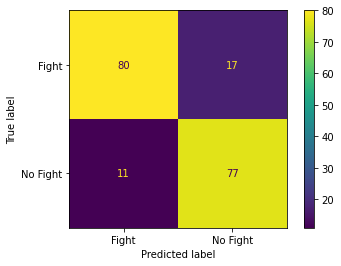

In [38]:
confusion_matrix = metrics.confusion_matrix(actual, predicted_new)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fight', 'No Fight'])

cm_display.plot()
plt.show()

In [39]:
print(f'Precision is: {metrics.precision_score(actual,predicted_new)}')
print(f'Recall is: {metrics.recall_score(actual,predicted_new)}')
print(f'F1 score is: {metrics.f1_score(actual,predicted_new)}')

Precision is: 0.8191489361702128
Recall is: 0.875
F1 score is: 0.8461538461538463


In [40]:
def predict_video(video_file_path):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    predicted_labels_probabilities = []
    predicted_label_lst = []
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    avg = [0,0]
    for i in range(SEQUENCE_LENGTH):
        
        predicted_labels_probabilities.append(model.predict(np.expand_dims(frames_list[i], axis = 0))[0])
        avg[0] += predicted_labels_probabilities[len(predicted_labels_probabilities)-1][0]
        avg[1] += predicted_labels_probabilities[len(predicted_labels_probabilities)-1][1]
        
        # Get the index of class with highest probability.
        #predicted_label_lst.append(np.argmax(predicted_labels_probabilities))
    
    #count_0 = predicted_label_lst.count(0)
    #count_1 = predicted_label_lst.count(1)
    
    avg[0] /= 20
    avg[1] /= 20
    if avg[0] > avg[1]:
        predicted_label = 0
    else:
        predicted_label = 1
    
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {avg[predicted_label]}')
        
    video_reader.release()

In [54]:
# Specifying video to be predicted
input_video_file_path = "test3.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path)


1/1 [==============================] - 0s 38ms/step
Predicted: noFire
Confidence: 0.9430145367980003
